<a href="https://colab.research.google.com/github/rakibulhaque9954/sentiment-analysis-imdb/blob/main/IMDB_sentiment_analysis_Reformer_Transformer_LSH_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acknowledgement

**Based on research by members of Google Brain, Google Research, Univerity of Toronto**<br>
Original Transformer Paper Link: https://arxiv.org/pdf/1706.03762.pdf

Efficiecnt Transformers Paper Link: https://arxiv.org/pdf/2009.06732.pdf

Reformer Transformer Paper Link: https://arxiv.org/pdf/2001.04451.pdf

***The Following Model is based on the famous Reformer Upgraded Transformer Model***


# Imports

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Layer
from keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from keras.layers import MultiHeadAttention, LayerNormalization
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

In [3]:
BATCH_SIZE = 64

In [53]:
train_ds, val_ds, test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

In [5]:
for review,label in train_ds.take(1):
  print("Review:",review.numpy())
  print("Label:",label.numpy())


Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0


## Standardization

In [6]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [7]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

## Vectorization

In [8]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [9]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int', # 'count' for bag of words and 'binary' for one hot vector
    output_sequence_length=SEQUENCE_LENGTH
)

In [10]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [11]:
len(vectorize_layer.get_vocabulary())

10000

In [12]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [13]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [14]:
vectorize_layer.get_vocabulary()[0:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [15]:
for review,label in train_dataset.take(1):
  print("Review:",review)
  print("Label:",label.numpy())


Review: tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   

## Datasets Prefecthing and Batching

In [16]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Modeling

<hr>
<h4>Model Architecture (only Encoder)</h4>
<hr>
<img src='https://miro.medium.com/v2/resize:fit:490/1*THykpgtL058A9EpkstnUJQ.png'>

***Step Wise Explanation:***
- Transformer Encoder Block: In sentiment analysis, we usually leverage the transformer encoder architecture. It excels at capturing contextual information from the input text.
- Contextual Vectors: The encoder processes the input text and produces contextual vectors for each word or subword in the sequence. These vectors contain rich information about the words and their relationships within the context of the sentence.
- Flattening: After obtaining the contextual vectors, you can flatten or concatenate them into a single vector representation. This helps in summarizing the entire input sequence into a fixed-size representation.
- Fully Connected Layer: The flattened vectors are then passed through a fully connected neural network layer. This layer typically consists of multiple neurons or units.
- Sigmoid Activation: To perform binary sentiment classification (positive/negative), a sigmoid activation function is commonly used in the output layer. It squashes the values to the range [0, 1], making it suitable for binary classification.

<h4>Inside LSH-Attention Layer</h4>
<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-01_at_6.28.07_PM.png'>

***Step Wise Explanation:***

- LSHAttention Mechanism: Unlike traditional attention mechanisms, LSHAttention (Locality Sensitive Hashing Attention) is an efficient approximate method designed to speed up the attention calculation. It uses hashing to group similar vectors (queries and keys) together, thus reducing the computational cost.
- Bucketing: In the LSHAttention mechanism, a random rotation is applied to the input data to distribute it into different buckets based on similarity. By grouping these vectors, only vectors in the same or nearby buckets are compared, which is a more efficient approach than comparing every vector to every other vector.
- Look-One-Back Strategy: Given the data in chunks (or buckets), a mechanism is employed to ensure that a chunk has some contextual information from the preceding chunk. This "look-one-back" strategy helps in providing continuity and better context when calculating attention scores within and across these chunks.
- Attention Score Calculation: Within these buckets, attention scores are calculated, typically using the dot product between query and key vectors. These scores determine the weight or importance of each value vector.
- Causal Masking (Optional): In scenarios like sequence-to-sequence tasks where future token information should not influence the current token, causal masking can be applied. This ensures that while calculating the attention score, only past and current information is utilized.
- Weighted Sum: After obtaining the attention weights using softmax, these weights are used to get a weighted sum of value vectors. This produces the output of the LSHAttention mechanism for each input query, giving us a new representation for our input sequence.
- Restoring Original Order: Since data gets reordered during bucketing, post-attention computation, the order of the sequence is restored to its original form using indices saved during the bucketing process.


## Reformer Architecture using LSH(Locality Sensitive Hashing) Attention

<img src="https://www.mihaileric.com/static/feedforward_layer_and_normalization-dfdcfbd00009f7f99eca73ae29f2dfb7-4ec3a.png">

### Positional Encoding

In [17]:
def positional_encoding(model_size, SEQUENCE_LENGTH): # d_model
  output = []
  for pos in range(SEQUENCE_LENGTH):
    PE = np.zeros((model_size)) # initilizing with zeros
    for i in range(model_size):
      if i % 2 == 0: # even positions, sin formula is used according to paper
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else: # odd positions, cos formula is used as mentioned in the paper
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE, axis = 0))

  out = tf.concat(output, axis=0)
  out = tf.expand_dims(out, axis=0)
  return tf.cast(out, dtype=tf.float32)

In [ ]:
print(positional_encoding(256, 32).shape)

(1, 32, 256)


### Input Embeddings

In [18]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embedding_dim):
    super(Embeddings, self).__init__()
    self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = positional_encoding(self.embedding_dim, self.sequence_length) # PE adding here
    return embedded_tokens + embedded_positions # final output for inputs

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0) # masking function for checking if there are pad tokens(0)



In [37]:
def look_one_back(x):
  """This function takes a tensor and creates a version of it where each entry also has access to the entry just before it
   (with the first entry looking at the last). This gives each chunk in LSH a small "look-back" to capture dependencies that
    might be present just outside its boundaries."""
  x_extra = tf.concat([x[:, -1:, ...],x[:, :-1, ...]], axis=1)
  return tf.concat([x, x_extra], axis=2)

def sticker_look_one_back(x):
  """Similar to the look_one_back function but specifically
  designed for the sticker (the sorted indices tensor)."""
  x_extra = tf.concat([x[:, -1:],x[:, :-1]], axis=1)
  # print("Shape of x:", tf.shape(x))
  # print("Shape of x_extra:", tf.shape(x_extra))
  return tf.concat([x, x_extra], axis=-1)

def causal_masker(a,b):
  """Creates a mask that ensures information only flows from past tokens to current tokens,
   and not the other way around. """
  a,b = tf.cast(a,dtype=tf.float32)+0.01, tf.cast(b,dtype=tf.float32)+0.01
  vals = tf.einsum('ipj,ipk->ipjk', b, 1/a) # calculating attention scores for each query and placing close to 0 values
  # to the future tokens and taking only the past into consideration, normally in trasnformers its straigh forward becuase of
  # single contextual vectors and comparsion but since tbis is broken into buckets a little more details is taken into consideration
  # but the mechanism is similar
  out = tf.cast(tf.cast(tf.cast(vals,dtype=tf.int32),dtype=tf.bool),dtype=tf.int32) # converting to 1s and 0s
  out = -out+1 # now reversing the 1s to become 0s and 0s to become 1s
  return tf.cast(out,dtype=tf.float32) # typecasting

class LSHAttention(tf.keras.layers.Layer):
    def __init__(self,bucket_size=8,n_hashes=1):
        super(LSHAttention,self).__init__()
        self.n_hashes = n_hashes
        self.bucket_size = bucket_size

    def call(self,query,key,value,causal_masking=False):
        R = tf.random.normal((tf.shape(query)[0], tf.shape(query)[-1], self.bucket_size//2))
        xR = tf.matmul(query, R) # creating values for similar data to fall under same bucket
        concat_xR = tf.concat([xR, -xR], axis=-1) # concatenating the negative and postiove of xR
        buckets = tf.math.argmax(concat_xR, axis=-1) # finding the bucket

        sticker = tf.argsort(buckets) # preserving the original order of the data points
        undo_sort = tf.argsort(sticker) # to reverse back to old order
        sorted_query = tf.gather(query, sticker, axis=1, batch_dims=1) # sorts the original order of query to sticker positions
        sorted_value = tf.gather(value, sticker, axis=1, batch_dims=1)

        chunked_query = tf.stack(tf.split(sorted_query, self.bucket_size, 1), 1) # dividing queries and values to chunks for easy computation
        chunked_value = tf.stack(tf.split(sorted_value, self.bucket_size, 1), 1)

        sticker = tf.stack(tf.split(sticker, self.bucket_size, 1), 1)
        new_sticker = sticker_look_one_back(sticker)

        lb_chunked_query = look_one_back(chunked_query) #  It can be thought of as a mechanism to provide some context from the previous chunk to the current one
        lb_chunked_value = look_one_back(chunked_value)

        score = tf.einsum('bhie,bhje->bhij', chunked_query, lb_chunked_query) # using dot product attention scores are calculated
        score /= tf.math.sqrt(tf.cast(query.shape[-1], tf.float32)) # scaling for softmax calculation

        if causal_masking == True:
            causal_mask = causal_masker(sticker, new_sticker) # no peeking into the future tokens mechanism for prediction
            dots += causal_mask * -1e-10 # applied by adding a large negative value (using the causal mask) to the attention scores
            # not needed for classification tasks but for predicting future tokens like for translation this can be crucial
        score = tf.nn.softmax(score) # softmax function applied to get attention weights
        output = tf.einsum('buij,buje->buie', score, lb_chunked_value) # These weights determine how much
        # each value in the lb_chunked_value should contribute to the output

        sorted_output = tf.reshape(output, (tf.shape(output)[0], tf.shape(query)[1], output.shape[3]))
        output = tf.gather(sorted_output, undo_sort, axis=1, batch_dims=1)
        # First, the output is reshaped to match the original shape of the input query.
        # Then, it is reordered back to its original order using the undo_sort indices.
        # This ensures that the final output has the same ordering as the input queries.
        return output

**Lets explain this:** <br>
query tf.Tensor(<br>
[[[0.31179297 0.8263413 ]<br>
  [0.6849456  0.0067091 ]<br>
  [0.78749514 0.3906511 ]<br>
  [0.29263055 0.99216926]<br>
  [0.95810425 0.55623317]<br>
  [0.16466296 0.13445711]<br>
  [0.13229859 0.5348098 ]<br>
  [0.57090175 0.50970507]]], shape=(1, 8, 2), dtype=float32)<br>
 - The query is passed, then using angular hash function the values are calculated and similar values are divided to different buckets.
  
buckets tf.Tensor([[3 4 3 3 3 3 3 3]], shape=(1, 8), dtype=int64)<br>

sticker tf.Tensor([[0 2 3 4 5 6 7 1]], shape=(1, 8), dtype=int32)<br>

- In order to return back to original order the stickers help preserving the old positions of the values.

undo_sort tf.Tensor([[0 7 1 2 3 4 5 6]], shape=(1, 8), dtype=int32)<br>

sorted query tf.Tensor(<br>
[[[0.31179297 0.8263413 ]<br>
  [0.78749514 0.3906511 ]<br>
  [0.29263055 0.99216926]<br>
  [0.95810425 0.55623317]<br>
  [0.16466296 0.13445711]<br>
  [0.13229859 0.5348098 ]<br>
  [0.57090175 0.50970507]<br>
  [0.6849456  0.0067091 ]]], shape=(1, 8, 2), dtype=float32)<br>

- The sorted query then helps placing the original query to sticker positions.
[0.31179297 0.8263413 ] for example these values are placed as they are in stickers which position 0 in the sorted query, but for the next values,  [0.6849456  0.0067091 ] which is at position 1 in query is sorted to last position because of its bucket value being 4 which is the highest and the rest is below that, thats why the sticker value shows last index wise but the original postion of the value is 1 and so on for all other values.

sorted value tf.Tensor(<br>
[[[0.31179297 0.8263413 ]<br>
  [0.78749514 0.3906511 ]<br>
  [0.29263055 0.99216926]<br>
  [0.95810425 0.55623317]<br>
  [0.16466296 0.13445711]<br>
  [0.13229859 0.5348098 ]<br>
  [0.57090175 0.50970507]<br>
  [0.6849456  0.0067091 ]]], shape=(1, 8, 2), dtype=float32)
  <br>

- The sorted values remain same as sorted query.

- The next step which is divide into chunks.

chunked query tf.Tensor(<br>
[[[[0.31179297 0.8263413 ]]

  [[0.78749514 0.3906511 ]]

  [[0.29263055 0.99216926]]

  [[0.95810425 0.55623317]]

  [[0.16466296 0.13445711]]

  [[0.13229859 0.5348098 ]]

  [[0.57090175 0.50970507]]

  [[0.6849456  0.0067091 ]]]], shape=(1, 8, 1, 2), dtype=float32)
- as it can be seen the values are divided into chunks belonging to different buckets.
- Shape Explanation:<br>
(1, 8, 1, 2)
The first dimension 1: Represents a batch size of 1. It indicates that there's one set of data being processed.<br>
The second dimension 8: Indicates that there are 8 vectors in this batch.<br>
The third dimension 1: It seems that each vector is in its own separate "group" or "chunk". This can be useful for operations that require individual attention to each vector, ensuring no cross-referencing between vectors.<br>
The fourth dimension 2: Shows that each vector in the batch consists of 2 elements.

  

In [32]:
### Test for representing attention mechanism ###
# a = tf.constant([[[[1], [0]], [[2], [0]], [[3], [0]], [[4], [0]]]])
# print(a)
# print('Query:', tf.concat([a[:, -1:], a[:, :-1]], axis=1))
# print('Key:', tf.concat([a, tf.concat([a[:, -1:], a[:, :-1]], axis=1)], axis=2))

tf.Tensor(
[[[[1]
   [0]]

  [[2]
   [0]]

  [[3]
   [0]]

  [[4]
   [0]]]], shape=(1, 4, 2, 1), dtype=int32)
Query: tf.Tensor(
[[[[4]
   [0]]

  [[1]
   [0]]

  [[2]
   [0]]

  [[3]
   [0]]]], shape=(1, 4, 2, 1), dtype=int32)
Key: tf.Tensor(
[[[[1]
   [0]
   [4]
   [0]]

  [[2]
   [0]
   [1]
   [0]]

  [[3]
   [0]
   [2]
   [0]]

  [[4]
   [0]
   [3]
   [0]]]], shape=(1, 4, 4, 1), dtype=int32)


The above example is a simple example as how self attention between chunks will occur.

### Encoder Layer

In [33]:
from tensorflow.python.ops.math_ops import bucketize
class TransformerEncoder(Layer):
  def __init__(self, embedding_dims, dense_dims, bucket_size=5, n_hashes=1):
    super(TransformerEncoder, self).__init__()
    self.embedding_dims = embedding_dims
    self.dense_dims = dense_dims
    self.attention = LSHAttention(bucket_size=bucket_size)

    self.dense_proj = tf.keras.Sequential([
        Dense(self.dense_dims, activation="relu"),
        Dense(self.embedding_dims),
    ])
    self.layernorm_1 = LayerNormalization()
    self.layernorm_2 = LayerNormalization()
    self.supports_masking = True

  def call(self, inputs, mask=None):
    # print(mask)
    if mask is not None:
      mask = tf.cast(mask[:, tf.newaxis, :], dtype='int32')
      # print(mask)
      T = tf.shape(mask)[2]
      padding_mask = tf.repeat(mask, T, axis=1)
      # print(padding_mask)

    attention_output = self.attention(query=inputs, value=inputs, key=inputs, causal_masking=False)

    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

In [25]:
##### Test for Encoder #####
# test_input = tf.random.uniform((1, 10, 256))
# test_mask = tf.cast(tf.random.uniform((1, 10)) > 0.5, tf.int32)
# encoder = TransformerEncoder(embedding_dims=256, dense_dims=512, num_heads=8)(output_embed)
# print(encoder.shape)


### Full Transfomers Model for sentiment classification

In [26]:
EMBEDDING_DIMS = 128
NUM_LAYERS = 1
NUM_EPOCHS = 10
LATENT_DIMS = 1024

In [34]:
encoder_inputs = Input(shape=(None,), dtype='int64', name='input')
embeddings = Embeddings(SEQUENCE_LENGTH, VOCAB_SIZE, EMBEDDING_DIMS)
x = embeddings(encoder_inputs)



for _ in range(NUM_LAYERS): # there can be N number of layers as mentioned by paper
  x = TransformerEncoder(EMBEDDING_DIMS, LATENT_DIMS)(x)

x = Flatten()(x) # flattening all the contextual vectors

output = Dense(1, activation='sigmoid')(x) # classification

sentiment_transformer = tf.keras.Model(encoder_inputs, output, name='LSH_reformer_transformer')

sentiment_transformer.summary()

Shape of x: Tensor("transformer_encoder_3/lsh_attention_3/Shape_2:0", shape=(3,), dtype=int32)
Shape of x_extra: Tensor("transformer_encoder_3/lsh_attention_3/Shape_3:0", shape=(3,), dtype=int32)
Model: "LSH_reformer_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 embeddings_4 (Embeddings)   (None, 250, 128)          1280000   
                                                                 
 transformer_encoder_3 (Tra  (None, 250, 128)          263808    
 nsformerEncoder)                                                
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense_8 (Dense)             (None, 1)      

# Training

## BLEU Metric

In [ ]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

## Compilation and Fitting

In [38]:
sentiment_transformer.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)



In [39]:
history = sentiment_transformer.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

Epoch 1/10
391/391 [==============================] - 48s 104ms/step - loss: 0.7241 - accuracy: 0.5046 - val_loss: 0.7141 - val_accuracy: 0.4967
Epoch 2/10
391/391 [==============================] - 11s 29ms/step - loss: 0.7083 - accuracy: 0.5193 - val_loss: 0.7071 - val_accuracy: 0.4968
Epoch 3/10
391/391 [==============================] - 11s 29ms/step - loss: 0.6948 - accuracy: 0.5381 - val_loss: 0.7067 - val_accuracy: 0.4971
Epoch 4/10
391/391 [==============================] - 12s 30ms/step - loss: 0.6592 - accuracy: 0.6004 - val_loss: 0.6253 - val_accuracy: 0.6938
Epoch 5/10
391/391 [==============================] - 11s 29ms/step - loss: 0.5573 - accuracy: 0.7164 - val_loss: 0.6424 - val_accuracy: 0.6232
Epoch 6/10
391/391 [==============================] - 12s 29ms/step - loss: 0.4257 - accuracy: 0.8062 - val_loss: 0.4459 - val_accuracy: 0.7912
Epoch 7/10
391/391 [==============================] - 12s 30ms/step - loss: 0.3548 - accuracy: 0.8438 - val_loss: 0.4931 - val_accuracy

In [ ]:
sentiment_transformer.save('transformer.hdf5')

# Testing and Evaluation

## Model loss and accuracy plots

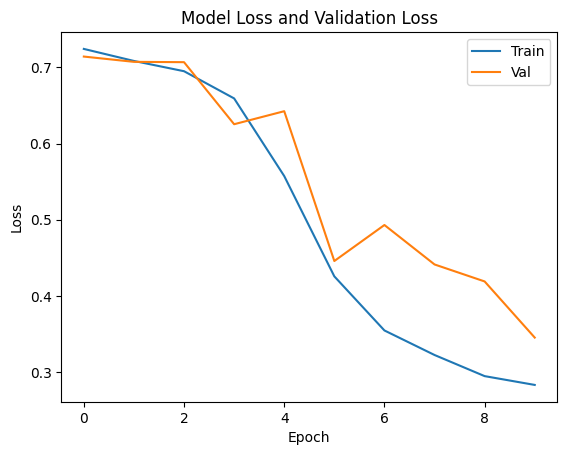

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()


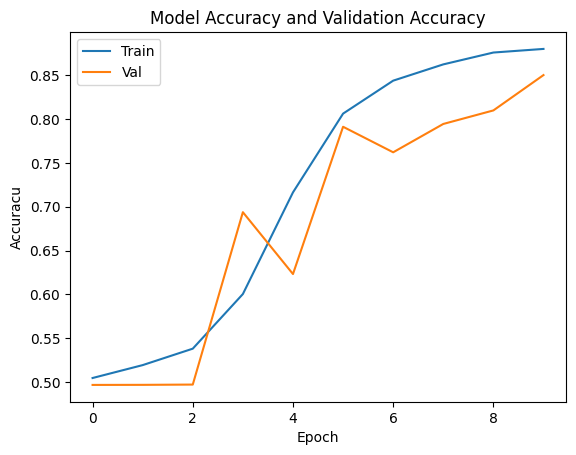

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracu')
plt.legend(['Train', 'Val'])
plt.show()


##Evaluation

In [54]:
test_dataset=test_ds.map(vectorizer) # vectorizing
test_dataset=test_dataset.batch(BATCH_SIZE) # batching
sentiment_transformer.evaluate(test_dataset)

196/196 [==============================] - 3s 16ms/step - loss: 0.3467 - accuracy: 0.8459


[0.3466813564300537, 0.8459200263023376]

***85% approx accuracy, given the training was just 10 epochs.***

# Testing

In [49]:
test_data = tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, they lived in a hole "],
                                              ["very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, so in all i didn't like this movie "],])


In [50]:
def vectorizer_test(review):
  return vectorize_layer(review)

test_dataset = test_data.map(vectorizer_test)




In [51]:
for review in test_dataset:
  if sentiment_transformer.predict(review) > 0.6:
    print("Positive", sentiment_transformer.predict(review))
  else:
    print("Negative", sentiment_transformer.predict(review))



1/1 [==============================] - 0s 20ms/step
Positive [[0.6181811]]
1/1 [==============================] - 0s 20ms/step
Negative [[0.30539992]]


# Evaluation Metrics

In [55]:
y_true = []
y_pred = []

for X_batch, y_batch in test_dataset:
    y_true.extend(y_batch)
    y_pred_batch = sentiment_transformer.predict(X_batch)
    y_pred.extend(np.round(y_pred_batch).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 21ms/step


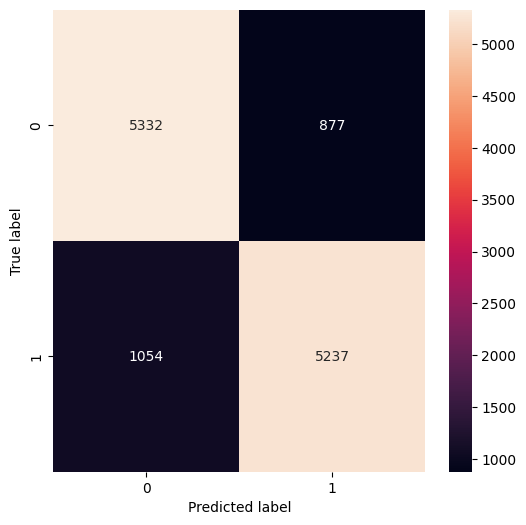

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [57]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      6209
           1       0.86      0.83      0.84      6291

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



***Very similar to other model's in accuracy, but the computation load is way lighter compared to a Traditional Transformer model.***